In [10]:
import os
import datetime
import errno

import numpy as np

import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats
from deepcell.utils.misc_utils import sorted_nicely
from deepcell.utils.tracking_utils import load_trks

## Cell segmentation

In [1]:
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

def load_data(path, mode, test_size=0.2, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Create fgbg model

In [3]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data  ## 61
n_skips = 1  # number of skip-connections (only for FC training)

# pixelwise transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

input_shape=(530, 530, 1)

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    last_only=False)

In [5]:
fgbg_model.load_weights("../seg_train_0816_convol/models/test/conv_fgbg_model.h5")

## Create pixelwise model

In [7]:
pixelwise_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    n_features=4 if separate_edge_classes else 3,
    receptive_field=receptive_field,
    norm_method=norm_method,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=input_shape)

In [8]:
pixelwise_model.load_weights("../seg_train_0816_convol/models/test/conv_edgeseg_model.h5")

## Post-processing

In [12]:
test = np.load("../test.npz")
x = test['X']
print(x.shape)

(66, 100, 530, 530, 1)


In [14]:
images = pixelwise_model.predict(x[0])[-1]
images_fgbg = fgbg_model.predict(x[0])[-1]

In [39]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.8

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [16]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=130, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)  

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


In [17]:
images.shape

(100, 530, 530, 4)

Image number: 3


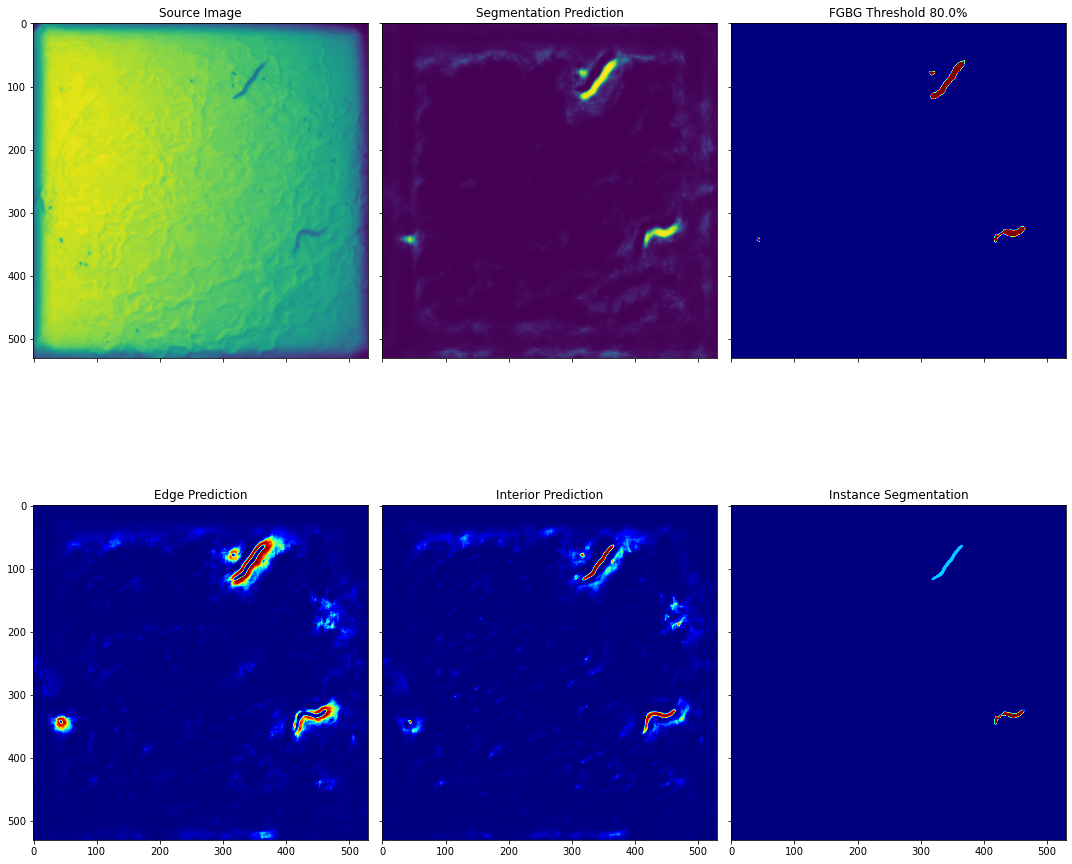

In [22]:
import matplotlib.pyplot as plt

#index = np.random.randint(low=0, high=X_test.shape[0])

index = 3
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(x[0][index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(images[index, ..., 0] + images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')



fig.tight_layout()
plt.show()

In [ ]:
#---------------------------------------------------------------------------------------------

In [25]:
d7 = np.load("../6819_3/D7_raw_1.npy")
x = d7

In [26]:
x.shape

(100, 530, 530, 1)

In [31]:
images = pixelwise_model.predict(x)[-1]
images_fgbg = fgbg_model.predict(x)[-1]

In [40]:
images.shape

(100, 530, 530, 4)

In [41]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.8

fg_thresh = images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

images_post_fgbg = images * fg_thresh

In [54]:
image_list = []

labeled_images = []
for i in range(images_post_fgbg.shape[0]):
    interior = images_post_fgbg[i, ..., 2] > .5
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=130, connectivity=1)  ## min_size=50
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1) 
    
image_list.append(labeled_images)

#labeled_images = []
#for i in range(images_post_fgbg.shape[0]):
#    interior = images_post_fgbg[i, ..., 2] > .5
#    labeled_image = label(interior)
#    labeled_image = morphology.remove_small_objects(
#        labeled_image, min_size=130, connectivity=1)  ## min_size=50
#    labeled_images.append(labeled_image)
#labeled_images = np.array(labeled_images)
#labeled_images = np.expand_dims(labeled_images, axis=-1)  

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (100, 530, 530, 1)


Image number: 99


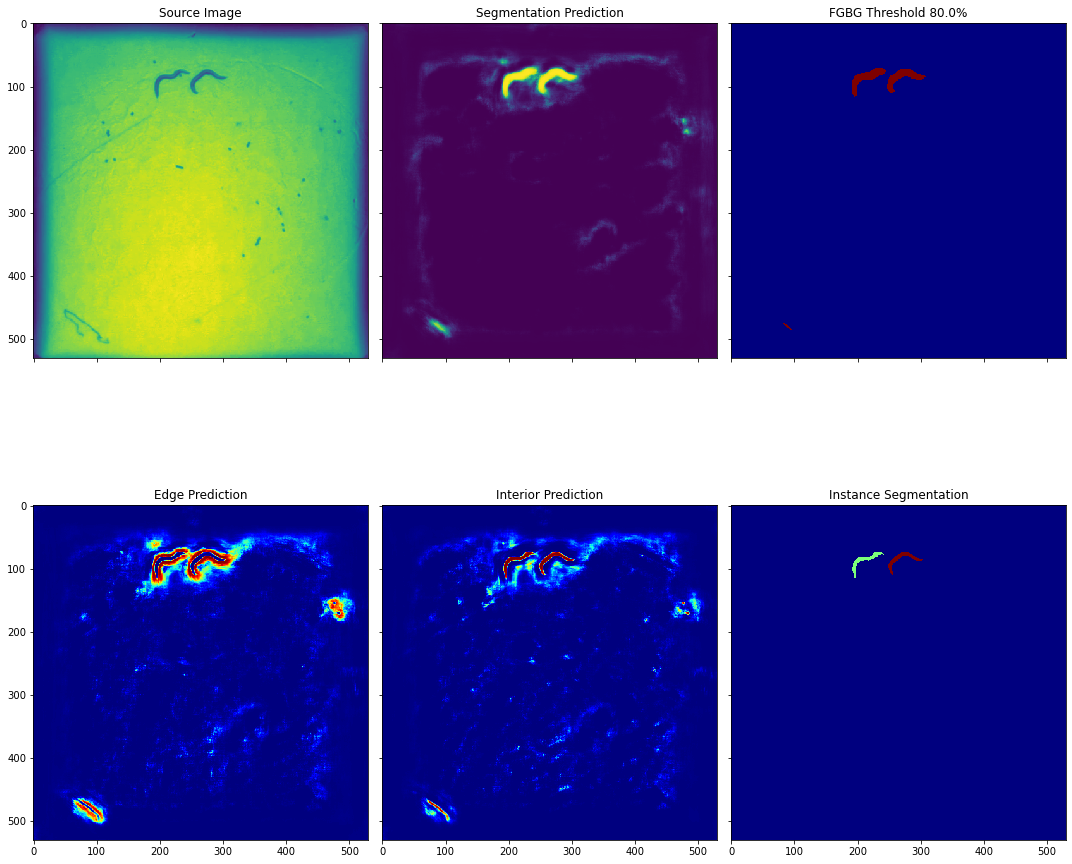

In [55]:
import matplotlib.pyplot as plt

#index = np.random.randint(low=0, high=X_test.shape[0])

index = 99
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(x[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(images[index, ..., 0] + images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')



fig.tight_layout()
plt.show()

unique_worm_ids:  [1, 2]
sequential ids:  [1, 2]


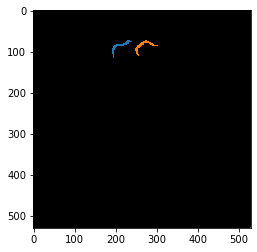

In [56]:
# save as gif
import gif
gif.plot_gif(labeled_images, '../segmented/6819_3/D7_seg_1.gif')

## Cell tracking

In [3]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = 'test_0814'

ROOT_DIR = '../train_0814'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

In [34]:
from deepcell import model_zoo

# Tracking model settings (These settings should mirror those from Part 1)
features = {'appearance', 'distance', 'neighborhood', 'regionprop'}
min_track_length = 9
neighborhood_scale_size = 30
batch_size = 16  # changed  
crop_dim = 100  # changed
in_shape = (crop_dim, crop_dim, 1)

# Re-instantiate the tracking model
tracking_model = model_zoo.siamese_model(
    input_shape=in_shape,
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

# Load model weights
siamese_weights_file = 'tracking_model_seed1_tl9.h5'
siamese_weights_file = os.path.join(MODEL_DIR, siamese_weights_file)

tracking_model.load_weights(siamese_weights_file)

print(in_shape)

(100, 100, 1)


In [16]:
tracking_model

Define critical parameters

In [9]:
# Key variables are lists to facilitate parameter sweeps if desired

# If model prediction for daughter is higher than this parameter,
# then daughter assignment made
division = [0.9]

# Parameter for cost matrix - if other possible assignments are higher than this,
# then a birth occurred
birth = [0.99]

# Parameter for cost matrix - if other possible assignments are higher than this,
# then a death occurred
death = [0.99]

# If two labels are beyond this distance they will not be compared
# (smaller distances -> faster tracking)
max_distance = 50

# Define Parameters that should not be changed
# (they are model dependent or training data dependent)
track_length = 9
neighborhood_scale_size = 30

In [2]:
import deepcell.tracking

In [6]:
npz = np.load("../test.npz")

In [7]:
raw = npz['X']
seg = npz['y']
print(raw.shape)
print(seg.shape)

(66, 100, 530, 530, 1)
(66, 100, 530, 530, 1)


In [12]:
raw_0 = raw[0]
seg_0 = seg[0]

In [20]:
trial = deepcell.tracking.cell_tracker(
    raw_0, seg_0, tracking_model,
    max_distance=max_distance,
    track_length=track_length,
    division=division[0],
    birth=birth[0],
    death=death[0],
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

In [22]:
trial

In [25]:
#trial.track_cells()

In [50]:
data = '../test.trks'

In [51]:
trks = load_trks(data)

In [52]:
raw = trks['X']
seg = trks['y']

print(raw.shape)
print(seg.shape)

(66, 100, 530, 530, 1)
(66, 100, 530, 530, 1)


In [54]:
# The tracker requires normalized images as input
def image_norm(img):
    return (img - np.mean(img)) / np.std(img)

# Go through each batch (movie) in each dataset
for batch_num, (lineage, raw, tracked) in enumerate(zip(trks['lineages'], trks['X'], trks['y'])):        
    # Normalize raw images
    for frame in range(raw.shape[0]):
        raw[frame, :, :, 0] = image_norm(raw[frame, :, :, 0]) 

    #print(raw.shape)
    #print(tracked.shape)
        # Track each movie with each division parameter
    print('Tracking: Dataset {}, Batch {}'.format(set_num, batch_num))
    # Track with the selected parameters
    trial = deepcell.tracking.cell_tracker(
        raw, tracked, tracking_model,
        max_distance=max_distance,
        track_length=track_length,
        division=div_param,
        birth=birth_param,
        death=death_param,
        neighborhood_scale_size=neighborhood_scale_size,
        features=features,
        crop_dim=100)

    try:
        trial.track_cells()
    except ValueError:
        print("ValueError occurs!")
        pass

Tracking: Dataset 0, Batch 0
ValueError occurs!
Tracking: Dataset 0, Batch 1
ValueError occurs!
Tracking: Dataset 0, Batch 2
ValueError occurs!
Tracking: Dataset 0, Batch 3
ValueError occurs!
Tracking: Dataset 0, Batch 4
Tracking: Dataset 0, Batch 5
Tracking: Dataset 0, Batch 6
Tracking: Dataset 0, Batch 7
Tracking: Dataset 0, Batch 8
Tracking: Dataset 0, Batch 9
Tracking: Dataset 0, Batch 10
Tracking: Dataset 0, Batch 11
Tracking: Dataset 0, Batch 12
Tracking: Dataset 0, Batch 13
Tracking: Dataset 0, Batch 14
Tracking: Dataset 0, Batch 15
Tracking: Dataset 0, Batch 16
Tracking: Dataset 0, Batch 17
ValueError occurs!
Tracking: Dataset 0, Batch 18
ValueError occurs!
Tracking: Dataset 0, Batch 19
Tracking: Dataset 0, Batch 20
Tracking: Dataset 0, Batch 21
Tracking: Dataset 0, Batch 22
Tracking: Dataset 0, Batch 23
Tracking: Dataset 0, Batch 24
ValueError occurs!
Tracking: Dataset 0, Batch 25
ValueError occurs!
Tracking: Dataset 0, Batch 26
ValueError occurs!
Tracking: Dataset 0, Batch 27

In [55]:
trial.y.shape

(100, 530, 530, 1)

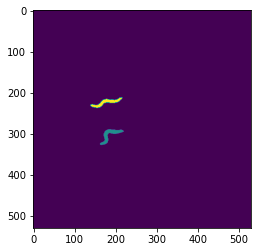

In [59]:
import matplotlib.pyplot as plt

plt.imshow(trial.y[3])

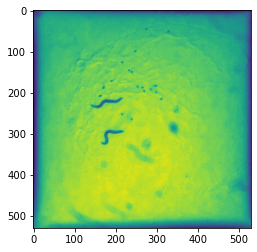

In [60]:
plt.imshow(trial.x[0])

unique_worm_ids:  [1, 2]
sequential ids:  [1, 2]


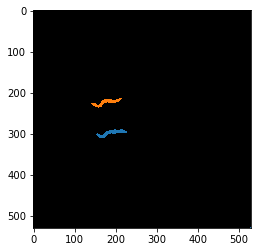

In [61]:
import gif

gif.plot_gif(trial.y, '../test_npz_tracked.gif', raw=False, sequential=False)

unique_worm_ids:  [28, 30]
sequential ids:  [1, 2]


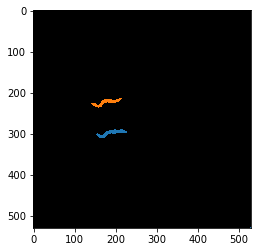

In [63]:
# This corresponds to the D12 last mask.npy check unique_worm_ids
gif.plot_gif(np.load('../6823_3/D12_mask_2.npy'), '../6823_3/gif/D12_mask_2.gif', raw=False, sequential=False)

In [93]:
# check 6819_3: D7_mask_1

X1 = np.load("../6819_3/D7_mask_1.npy")
y1 = np.load("../6819_3/D7_mask_1.npy")

X2 = np.load("../6819_3/D7_mask_2.npy")  # Stupid, because need at least 2 trks
y2 = np.load("../6819_3/D7_mask_2.npy")

In [94]:
import lineage
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import sys
import time
import pandas as pd


# Input file
fN = h5py.File("../6819_3/6819_3_featuresN.hdf5")

# Define dorsal and ventral coordinates
coordinates = fN['coordinates']
dorsal = coordinates['dorsal_contours']
ventral = coordinates['ventral_contours']

# trajectory_data and timeseries_data
traj = pd.read_hdf("../6819_3/6819_3_featuresN.hdf5", '/trajectories_data')
timeseries = fN['timeseries_data']

# Get wells - data from timeseries_data, at position [2]
wells = ['A5', 'A6', 'A7', 'A8', 'B5', 'B6', 'B7', 'B8', 'C5', 'C6', 'C7', 'C8', 'D5', 'D6', 'D7', 'D8']
#wells = [each.encode() for each in wells]

well_dict = {}
for each in wells:
    well_dict[each] = []
    
#print('A1'.encode().decode())
for i, each in enumerate(timeseries[:]):  # "i" == index
    well = each[2].decode()
    #well_dict[well] = []
    if well in well_dict.keys():
        well_dict[well].append(i)

d7_1 = lineage.make_lineage(traj, well_dict, 'D7', "6819_3", "../6819_3/D7_mask_1.npy", 1)
d7_2 = lineage.make_lineage(traj, well_dict, 'D7', "6819_3", "../6819_3/D7_mask_2.npy", 2)

In [95]:
from deepcell.utils.tracking_utils import load_trks, trks_stats, save_trks
save_trks('../6819_3/D7_mask_1and2.trks', [d7_1,d7_2], [X1, X2], [y1, y2])  #颠倒的顺序，因为想要引用d7_1

In [96]:
trk = load_trks('../6819_3/D7_mask_1and2.trks')

Tracking: Dataset 0, Batch 0
ValueError occurs!
unique_worm_ids:  [1, 2, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294]
sequential ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5

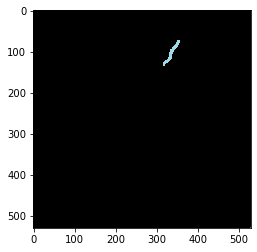

In [103]:
# The tracker requires normalized images as input
def image_norm(img):
    return (img - np.mean(img)) / np.std(img)

trials = []

# Go through each batch (movie) in each dataset
for batch_num, (lineage, raw, tracked) in enumerate(zip(trk['lineages'], trks['X'], trks['y'])):        
    # Normalize raw images
    for frame in range(raw.shape[0]):
        raw[frame, :, :, 0] = image_norm(raw[frame, :, :, 0]) 

    #print(raw.shape)
    #print(tracked.shape)
        # Track each movie with each division parameter
    print('Tracking: Dataset {}, Batch {}'.format(set_num, batch_num))
    # Track with the selected parameters
    trial = deepcell.tracking.cell_tracker(
        raw, tracked, tracking_model,
        max_distance=max_distance,
        track_length=track_length,
        division=div_param,
        birth=birth_param,
        death=death_param,
        neighborhood_scale_size=neighborhood_scale_size,
        features=features,
        crop_dim=100)

    try:
        trial.track_cells()

    except ValueError:
        print("ValueError occurs!")
        pass
    
    gif_name = '../test_6819_3_D7_%s.gif' % batch_num
    gif.plot_gif(trial.y, gif_name)

In [98]:
np.unique(trial.y)

array([  0,   1,   2, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294], dtype=int32)

Processing raw video.


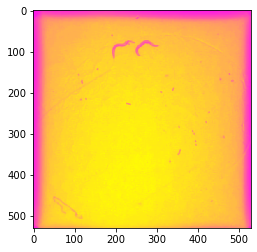

In [105]:
gif.plot_gif(np.load("../6819_3/D7_raw_2.npy"), '../6819_3/gif/D7_raw_2.gif', raw=True)

In [108]:
gif.plot_gif(trial.X, '../trial_x.gif', raw=True)

AttributeError: 'CellTracker' object has no attribute 'X'

In [ ]:
# Try segmentation then... 